In [1]:
import sqlite3
from sqlite3 import Error
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bq_helper
from bq_helper import BigQueryHelper
usfs = BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="usfs_fia")
from matplotlib import dates
import seaborn as sns

In [2]:
#function for creating the dates for the x-axis for regression plots
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')


In [3]:
usfs.list_tables()

['condition',
 'estimated_forestland_acres',
 'estimated_timberland_acres',
 'plot',
 'plot_tree',
 'population',
 'population_estimation_unit',
 'population_evaluation',
 'population_evaluation_group',
 'population_evaluation_type',
 'population_stratum',
 'population_stratum_assign',
 'tree']

See what's in plot_tree

In [4]:
usfs.table_schema('tree')

,name,type,mode,description
0,tree_sequence_number,INTEGER,NULLABLE,Foreign key linking the tree regional biomass ...
1,plot_sequence_number,INTEGER,NULLABLE,Foreign key linking the subplot record to the ...
2,previous_tree_sequence_number,INTEGER,NULLABLE,Foreign key linking the tree to the previous i...
3,tree_inventory_year,INTEGER,NULLABLE,The year that best represents when the invento...
4,tree_state_code,INTEGER,NULLABLE,Bureau of the Census Federal Information Proce...
...,...,...,...,...
250,inc5yrht_pnwrs,STRING,NULLABLE,
251,inc5yr_pnwrs,STRING,NULLABLE,
252,ring_count_inner_2inches_pnwrs,STRING,NULLABLE,
253,ring_count_pnwrs,STRING,NULLABLE,


From the description, find the code of the tree (is it unique?)

In [5]:
usfs.table_schema('tree')[usfs.table_schema('tree')["description"] == "An identifier for a plot. Along with state code, inventory year, tree survey unit code, County code and/or some other combinations of variables, PLOT may be used to uniquely identify a plot."].index.tolist()

[7]

In [12]:
usfs.table_schema('tree').loc[usfs.table_schema('tree').type=="STRING"].head(45)

,name,type,mode,description
15,tree_status_code_name,STRING,NULLABLE,A code indicating whether the sample tree is l...
17,species_common_name,STRING,NULLABLE,An FIA tree species code. Refer to appendix F ...
18,species_scientific_name,STRING,NULLABLE,An FIA tree species code. Refer to appendix F ...
20,species_group_code_name,STRING,NULLABLE,A code assigned to each tree species in order ...
23,diameter_height_code_name,STRING,NULLABLE,A code indicating the location at which diamet...
26,height_method_code_name,STRING,NULLABLE,A code indicating how length (height) was dete...
29,tree_class_code_name,STRING,NULLABLE,A code indicating the general quality of the t...
32,crown_class_code_name,STRING,NULLABLE,A code indicating the amount of sunlight recei...
35,cause_death_agent_code_name,STRING,NULLABLE,"When PLOT.MANUAL 1.0, this variable was collec..."
38,damage_location_1_name,STRING,NULLABLE,A code indicating where damage (meeting or exc...


In [15]:
usfs.table_schema('tree')["description"][133]

'A code indicating the general quality of the tree. Prior to the merger of the Southern and Southeastern Research Stations (INVYR \uf0a31997), a growing-stock classification (code 2) was only assigned to species that were considered to have commercial value. Since the merger (INVYR >1997), code 2 has been applied to all tree species meeting the growing-stock form, grade, size and soundness requirements, regardless of commercial value. Only collected by certain FIA work units (SURVEY.RSCD = 33).'

Found that it corresponds to "tree_phase_2_plot_number"

In [147]:
for i in usfs.table_schema('tree')["name"]:
    print(i)

tree_sequence_number
plot_sequence_number
previous_tree_sequence_number
tree_inventory_year
tree_state_code
tree_survey_unit_code
tree_county_code
tree_phase_2_plot_number
subplot_number
tree_record_number
condition_class_number
azimuth
horizontal_distance
previous_condition_number
tree_status_code
tree_status_code_name
species_code
species_common_name
species_scientific_name
species_group_code
species_group_code_name
current_diameter
diameter_height_code
diameter_height_code_name
total_height
height_method_code
height_method_code_name
actual_height
tree_class_code
tree_class_code_name
compacted_crown_ratio
crown_class_code
crown_class_code_name
tree_grade_code
cause_death_agent_code
cause_death_agent_code_name
rotten_and_missing_cull
damage_location_1
damage_location_1_name
damage_type_1
damage_type_1_name
damage_severity_1
damage_severity_1_name
damage_location_2
damage_location_2_name
damage_type_2
damage_type_2_name
damage_severity_2
damage_severity_2_name
decay_class_code
decay_cl

In [148]:
query1 = f"""
    SELECT
        species_common_name,
        plot_state_code_name,
        plot_phase_2_plot_number,
        measurement_month,
        measurement_year,
        current_diameter as avg_dia,
        total_height as avg_heig,
        
    FROM
        `bigquery-public-data.usfs_fia.plot_tree`
    WHERE
        total_height > 0
        AND plot_state_code_name = 'California'
    GROUP BY
        species_common_name,
        plot_state_code_name,
        plot_phase_2_plot_number,
        measurement_month,
        measurement_year,
        current_diameter,
        total_height
    ;        """
response1 = usfs.query_to_pandas_safe(query1, max_gb_scanned=10)

In [149]:
response1['date'] = pd.to_datetime({'year':response1['measurement_year'],'month':response1['measurement_month'],'day': np.ones(response1["measurement_year"].size)})
# response1.head()
len(response1)

335747

In [150]:
response1.plot_phase_2_plot_number.value_counts()

28       547
18       444
55       432
24       430
25       419
        ... 
60142      1
97101      1
54833      1
51911      1
57192      1
Name: plot_phase_2_plot_number, Length: 6083, dtype: int64

In [151]:
response1[response1.species_common_name == "Pacific madrone"]

,species_common_name,plot_state_code_name,plot_phase_2_plot_number,measurement_month,measurement_year,avg_dia,avg_heig,date
46,Pacific madrone,California,153,11,1991,2.800000,23,1991-11-01
52,Pacific madrone,California,184,7,1991,6.200000,46,1991-07-01
84,Pacific madrone,California,141,7,1991,9.700000,54,1991-07-01
135,Pacific madrone,California,3,10,1991,14.100000,69,1991-10-01
249,Pacific madrone,California,106,8,1991,2.000000,17,1991-08-01
...,...,...,...,...,...,...,...,...
335527,Pacific madrone,California,73243,5,2018,9.900000,39,2018-05-01
335654,Pacific madrone,California,97409,10,2018,9.300000,33,2018-10-01
335670,Pacific madrone,California,88939,7,2018,9.000000,66,2018-07-01
335720,Pacific madrone,California,82034,7,2018,15.200000,39,2018-07-01


In [152]:
# sugar_maple = response1.loc[(response1.plot_phase_2_plot_number == 33) & (response1.species_common_name =="Pacific madrone")]

pacific_madrone = response1.loc[(response1.plot_phase_2_plot_number == 28) & (response1.species_common_name =="Pacific madrone")]
pacific_madrone.plot_phase_2_plot_number.value_counts()


28    6
Name: plot_phase_2_plot_number, dtype: int64

In [153]:
# pacific_madrone.loc[(pacific_madrone.avg_heig>100) & (pacific_madrone.plot_phase_2_plot_number == 57038)]
taller = pacific_madrone.loc[(pacific_madrone.avg_heig>50)]


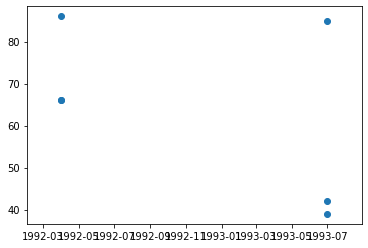

In [154]:
# sns.lmplot(data = taller, x = "date",y = "avg_heig")
plt.scatter(pacific_madrone["date"], pacific_madrone["avg_heig"])

In [155]:
#convert to something that sns.regplot can handle
date_maple = dates.datestr2num(sugar_maple.date.astype(str))
sugar_maple_dtn = sugar_maple.copy()
sugar_maple_dtn['dtn'] = date_maple

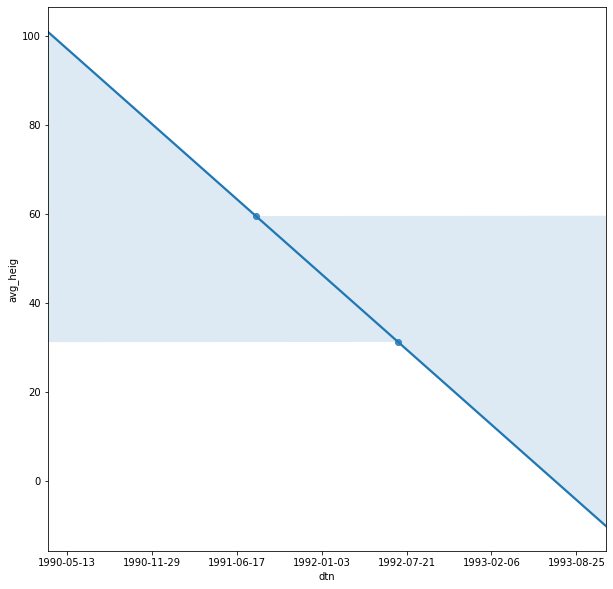

In [156]:
fig, ax = plt.subplots(figsize = (10,10))
sns.regplot(data = sugar_maple_dtn, x = "dtn",y = "avg_heig")
ax.xaxis.set_major_formatter(fake_dates)


In [96]:
query2 = """
SELECT
    species_common_name,
    measurement_year,
    plot_county_code,
FROM
    `bigquery-public-data.usfs_fia.plot_tree`
WHERE
    total_height > 0
    AND (plot_state_code_name = 'Oklahoma'
    OR plot_state_code_name = 'Texas'
    OR plot_state_code_name = 'Arkansas'
    OR plot_state_code_name = 'Lousiana'
    OR plot_state_code_name = 'Mississippi'
    OR plot_state_code_name = 'Alabama'
    OR plot_state_code_name = 'Tennesse'
    OR plot_state_code_name = 'Kentucky'
    OR plot_state_code_name = 'Georgia'
    OR plot_state_code_name = 'Florida'
    OR plot_state_code_name = 'Virginia'
    OR plot_state_code_name = 'North Carolina'
    OR plot_state_code_name = 'South Carolina'
    OR plot_state_code_name = 'Puerto Rico')


    
GROUP BY
    species_common_name,
    measurement_year,
    plot_county_code
;        """
response2 = usfs.query_to_pandas_safe(query2, max_gb_scanned=10)

In [97]:
response2.groupby('species_common_name').sum().reset_index();
response2_ordered = response2.species_common_name.value_counts()

In [98]:
top5 = response2_ordered.head(10)
top5 = top5.reset_index()

In [99]:
top5

,index,species_common_name
0,red maple,5444
1,sweetgum,5417
2,loblolly pine,5378
3,water oak,5091
4,blackgum,4970
5,southern red oak,4942
6,white oak,4908
7,black cherry,4868
8,post oak,4812
9,flowering dogwood,4601


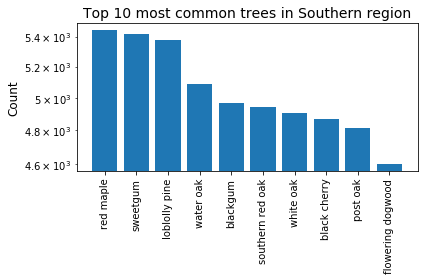

In [100]:
plt.bar(top5["index"],top5["species_common_name"])
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Top 10 most common trees in Southern region", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.savefig("top10_trees_Southern.png", dpi=100)

In [ ]:
query3 = """
SELECT
    tree_phase_2_plot_number,
    total_height as avg_heig,
    measurement_year,
    measurement_month,
    plot_county_code
FROM
    `bigquery-public-data.usfs_fia.plot_tree`
WHERE
    plot_state_code = 39
    AND total_height > 0

;        """
response3 = usfs.query_to_pandas_safe(query3, max_gb_scanned=10)